In [2]:
%pylab inline
from pysptools import abundance_maps
import pandas as pd
from scipy.io import loadmat

Populating the interactive namespace from numpy and matplotlib


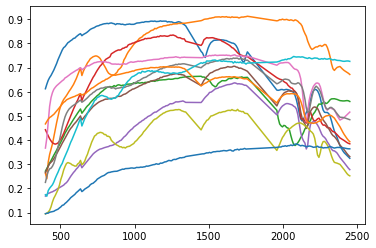

In [5]:
dataset = "cuprite"

d = loadmat("../input/reference-datasets/" + dataset + "/" + dataset + ".mat")
em = loadmat("../input/reference-datasets/" + dataset + "/endmembers/endmembers.mat")
dinfo = pd.read_csv("../input/reference-datasets/" + dataset + "/info.csv",header=None,index_col=None,names=["parameter",'value','unit'])

nrow = int(dinfo[dinfo['parameter'] == 'nrow'].value.values[0])
ncol = int(dinfo[dinfo['parameter'] == 'ncol'].value.values[0])

nbands = int(dinfo[dinfo['parameter'] == 'nbands'].value.values[0])
spec_start = dinfo[dinfo['parameter'] == 'spec_start'].value.values[0]
spec_end = dinfo[dinfo['parameter'] == 'spec_end'].value.values[0]

data = d['Y']
data = data / data.max()
try:
    spec_bands = d['SlectBands'].flatten()
except:
    spec_bands = arange(0,nbands)

# Define wavelength array
wavelength = linspace(spec_start,spec_end,nbands)
wavelength = wavelength[spec_bands]

if len(em['M']) > len(wavelength):
    endmembers = em['M'][spec_bands]
else:
    endmembers = em['M']

endmembers = endmembers.reshape(len(wavelength),-1)

a_map = em["A"].reshape((endmembers.shape[1],nrow,ncol)).T

hypercube = data.copy()
spectra = endmembers.T
hypercube = hypercube.reshape(len(wavelength), a_map.shape[1], a_map.shape[0]).T


figure(1)
plot(wavelength, spectra[0])
plot(wavelength, spectra[1])
plot(wavelength, spectra[2])
plot(wavelength, spectra[3])
plot(wavelength, spectra[4])
plot(wavelength, spectra[5])
plot(wavelength, spectra[6])
plot(wavelength, spectra[7])
plot(wavelength, spectra[8])
plot(wavelength, spectra[9])
plot(wavelength, spectra[10])
plot(wavelength, spectra[11])
plt.show()


In [6]:
def create_sythentic_hypercube(a_map, spectra, wavelength):
 
    '''
    Encodes a 2d image with spectral data to generate a synthetic hypercube.
    
    Inputs:
        a_map (N x M x L array) - 3D abundance map of target. Each channel in L corresponds to the
             abundance (between 0 and 1) of the spectral signature in the spectra array. 
             
        spectra (L x Q array) - Array of 1D spectral respones for each pixel. Number of array members
            should be equal to the maximum value in im (L). Q is sample points in wavelength space.
            
        wavelength (1 x Q array) - Array describing the wavelength value corresponding to the spectral
            response arrays.
    
    Output:
        hypercube (N X M x Q) - 3D synthetic hypercube.
        
        wavelength (1 x Q array) - Array describing the wavelength value corresponding to the spectral
            dimension of the hypercube.
    '''

    N,M,_ = a_map.shape
    L,Q = spectra.shape

    hypercube = zeros((N,M,Q))
    
    for i in range(L):
        hypercube += outer(a_map[:,:,i],spectra[i]).reshape((N,M,Q))

    return hypercube, wavelength

In [7]:
hypercube,wavelength = create_sythentic_hypercube(a_map, spectra, wavelength)

In [8]:
class ColourSystem:
    """A class representing a colour system.
    
    Assume pure white, illuminant E

    A colour system defined by the CIE x, y and z=1-x-y coordinates of
    its three primary illuminants and its "white point".

    reference: http://www.brucelindbloom.com/index.html?Eqn_RGB_XYZ_Matrix.html

    """
    # The CIE colour matching function for 380 - 780 nm in 5 nm intervals
    cmf = np.loadtxt('cie-cmf.txt', usecols=(1,2,3))
    wv = arange(380,785,5)
                         
    def __init__(self, wavelength):
        """Initialise the ColourSystem object.

        Pass vectors (ie NumPy arrays of shape (3,)) for each of the
        red, green, blue  chromaticities and the white illuminant
        defining the colour system.
        
        If wavelength is provided, then the CMF function will be re-scaled
        to be on the same sampling as the provided array.

        """

        # Chromaticities
        # The chromaticity matrix (RGB -> XYZ) and its inverse (XYZ -> RGB)
        # Illuminant 'E'
        self.M = array([[0.4887180,0.3106803,0.2006017],[0.1762044,0.8129847,0.0108109],[0.0000000,  0.0102048, 0.9897952]])
        self.MI = np.linalg.inv(self.M)

        self.cmf = array([interp(wavelength, self.wv, self.cmf[:,0]),
                          interp(wavelength, self.wv, self.cmf[:,1]),
                          interp(wavelength, self.wv, self.cmf[:,2])]).T
        
        self.wv = wavelength        
        self.N = np.sum(self.cmf[:,1] * ones((len(self.wv),)))

    def xyz_to_rgb(self, xyz):
        """
        Transform from xyz to rgb representation of colour.
        """
        rgb = self.MI.dot(xyz)
        
        # We're not in the RGB gamut: approximate by desaturating
        rgb[rgb<0] = 0
        rgb[rgb>1] = 1

        return rgb

    def spec_to_xyz(self, spec):
        """
        Convert a spectrum to an xyz point.
        """
        XYZ = np.sum(spec[:, np.newaxis] * self.cmf, axis=0)
        return XYZ / self.N

    def spec_to_rgb(self, spec):
        """Convert a spectrum to an rgb value."""
        xyz = self.spec_to_xyz(spec)
        return self.xyz_to_rgb(xyz)

In [9]:
cs = ColourSystem(wavelength)

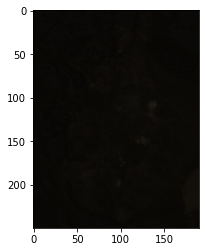

In [10]:
hypercube_RGB = zeros((hypercube.shape[0], hypercube.shape[1], 3))

for i in range(hypercube.shape[0]):
        for j in range(hypercube.shape[1]):
            hypercube_RGB[i,j,:3] = cs.spec_to_rgb(hypercube[i,j,:])

imshow(hypercube_RGB)